In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from time import time, sleep
from fpga_ctrl import FpgaControl

%load_ext autoreload
%autoreload 2

In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

# Utilities

In [2]:
# Global constants
SAMPLES_PER_LINE = 16384
GAINS_MAX = 32
LINES_MAX = 32
SAMPLE_W = 10
SAMPLE_N = 2 ** SAMPLE_W
SAMPLE_FREQ = 63.75

In [48]:
# Utility functions
def line_to_voltage(line):
    res = [((2 * 1.0) / SAMPLE_N) * ((w & (SAMPLE_N - 1)) - SAMPLE_N // 2) for w in line]
    return np.array(res)

def gain_to_voltage(gain):
    return [(1.0 / SAMPLE_N) * g for g in gain]

def gain_expand(gain, length=SAMPLES_PER_LINE):
    return [gain[x // (length // GAINS_MAX)] for x in range(length)]

def gain_expand_double(gain, length=SAMPLES_PER_LINE):
    return [gain[x // (length // GAINS_MAX)] for x in range(2*length)]

def gain_staircase(step_width=1, max_value=1024):
    step_val = max_value // GAINS_MAX
    return [step_val - 1 + step_val * step_width * (i // step_width) for i in range(GAINS_MAX)]

def line_complex_sin(offset = 0):
    return [int(512 + 200 * np.sin(2 * np.pi * offset * 1E6 / 127.5E6 + 2 * np.pi * i * 1E6 / 63.75E6) + 
                      100 * np.sin(2 * np.pi * offset * 2E6 / 127.5E6 + 2 * np.pi * i * 2E6 / 63.75E6 ) -
                      80 * np.sin(2 * np.pi * offset * 5E6 / 127.5E6 + 2 * np.pi * i * 5E6 / 63.75E6 ) +
                      20 * np.sin(2 * np.pi * offset * 8E6 / 127.5E6 + 2 * np.pi * i * 8E6 / 63.75E6 )) for i in range(SAMPLES_PER_LINE)]

def plot_line(title, line, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    # prepare line
    _line = line_to_voltage(line)
    # prepare gain
    _gain = gain_expand(gain_to_voltage(gain), len(line))
    # prepare time
    t = [1.0 / SAMPLE_FREQ * x for x in range(len(line))]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, _line, 'b-')
    if dots:
        ax1.plot(t, _line, 'ro')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Time, us')
    ax1.set_ylabel('ADC, V', color='b')
    ax2.set_ylabel('DAC, V', color='g')
    plt.tight_layout()
    plt.title(title)
    plt.savefig(title+".png")
    plt.show()

def plot_line_raw(title, line, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    # prepare line
    _line = [w & (SAMPLE_N - 1) for w in line]
    # prepare gain
    _gain = gain_expand(gain, len(line))
    # prepare time
    t = [x for x in range(len(line))]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, _line, 'b-')
    if dots:
        ax1.plot(t, _line, 'ro')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Sample n')
    ax1.set_ylabel('ADC code', color='b')
    ax2.set_ylabel('DAC code', color='g')
    plt.tight_layout()
    plt.show()

def plot_interleaved_lines(title, line0, line1, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    il_len = len(line0) * 2
    il_freq = SAMPLE_FREQ * 2
    # prepare line 0
    _line0 = line_to_voltage(line0)
    t0 = [1.0 / SAMPLE_FREQ * x for x in range(len(_line0))]
    # prepare line 1
    _line1 = line_to_voltage(line1)
    t1 = [1.0 / il_freq + 1.0 / SAMPLE_FREQ * x for x in range(len(_line0))]
    # prepare interleaved line
    il_line = [_line1[i//2] if i % 2 else _line0[i//2] for i in range(il_len)]
    # prepare gain
    _gain = gain_expand(gain_to_voltage(gain), il_len)
    # prepare time
    t = [1.0 / il_freq * x for x in range(il_len)]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, il_line, 'b-')
    if dots:
        ax1.plot(t0, _line0, 'ro')
        ax1.plot(t1, _line1, 'yo')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Time, us')
    ax1.set_ylabel('ADC, V', color='b')
    ax2.set_ylabel('DAC, V', color='g')
    plt.tight_layout()
    plt.show()

# Acquisition demonstration

## Connect FPGA

In [15]:
# init FTDI device
fpga = FpgaControl('ftdi://ftdi:2232:/', spi_freq=8E6)
# reload configuration (optional step - just to fill BRAM (DACGAIN registers) with initial values)
fpga.reload()
# reset fpga
fpga.reset()

## Do acquisition

### Checking all is well plugged

In [16]:
giOFFSET = 0 
gMAX = 1124

gain = [int(giOFFSET + ((gMAX-giOFFSET)*x*x*x/32/32/32)) for x in range(32)]

In [17]:
np.max(gain)

1021

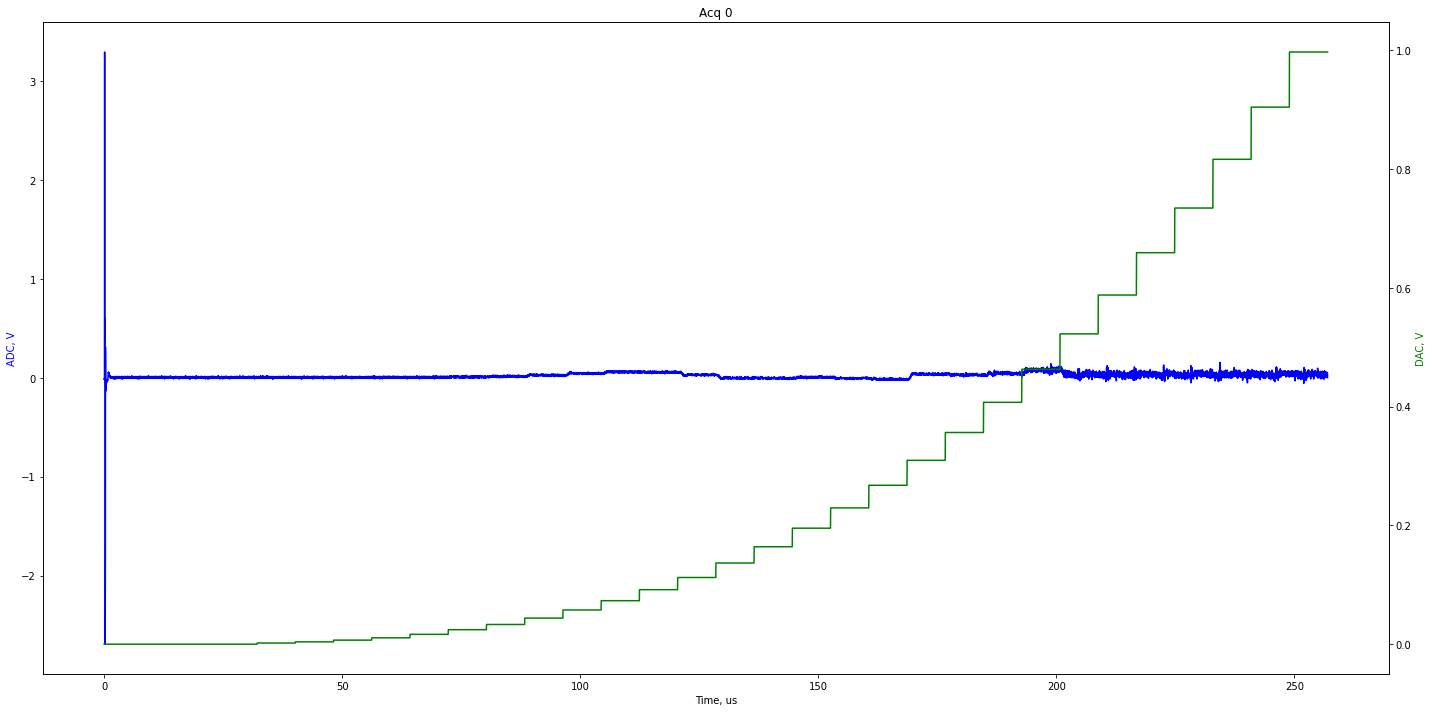

In [20]:
acq_res = fpga.do_acquisition(acq_lines=32, gain=gain, double_rate=True)
plot_line("Acq 0", acq_res[0], gain)

In [21]:
data = {}
data["gain"]=gain
data["double_rate"]="True"
for i in range(32):
    data[i]=acq_res[i]

In [22]:
import json

with open('32_lines_50R.json', 'w') as fp:
    json.dump(data, fp)

### Trying to find the optimal  pulse pattern for the piezo

In [23]:
with open('32_lines_50R.json', 'r') as fp:
    data = json.load(fp)

In [24]:
data.keys()

dict_keys(['gain', 'double_rate', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'])

In [118]:
even = np.array(data['0'])
odd = np.array(data['1'])
for k in range(16):
    if (k % 2) == 0:
        even = even + np.array(data[str(k)] )
    else:
        odd = odd + np.array(data[str(k)] )

line0 = np.array(data['0'])
line1 = np.array(data['1'])

mean1 = int(np.mean(even[400:2000]))
mean2 = int(np.mean(odd[400:2000]))
for k in range(400):
    even[k] = mean1
    odd[k] = mean2
    line1[k] = mean1
    line0[k] = mean2
    
AllPts = []    
for pt in range(len(even)):
    AllPts.append(even[pt])
    AllPts.append(odd[pt])
AllPts = np.array(AllPts)

In [119]:
len(AllPts)

32768

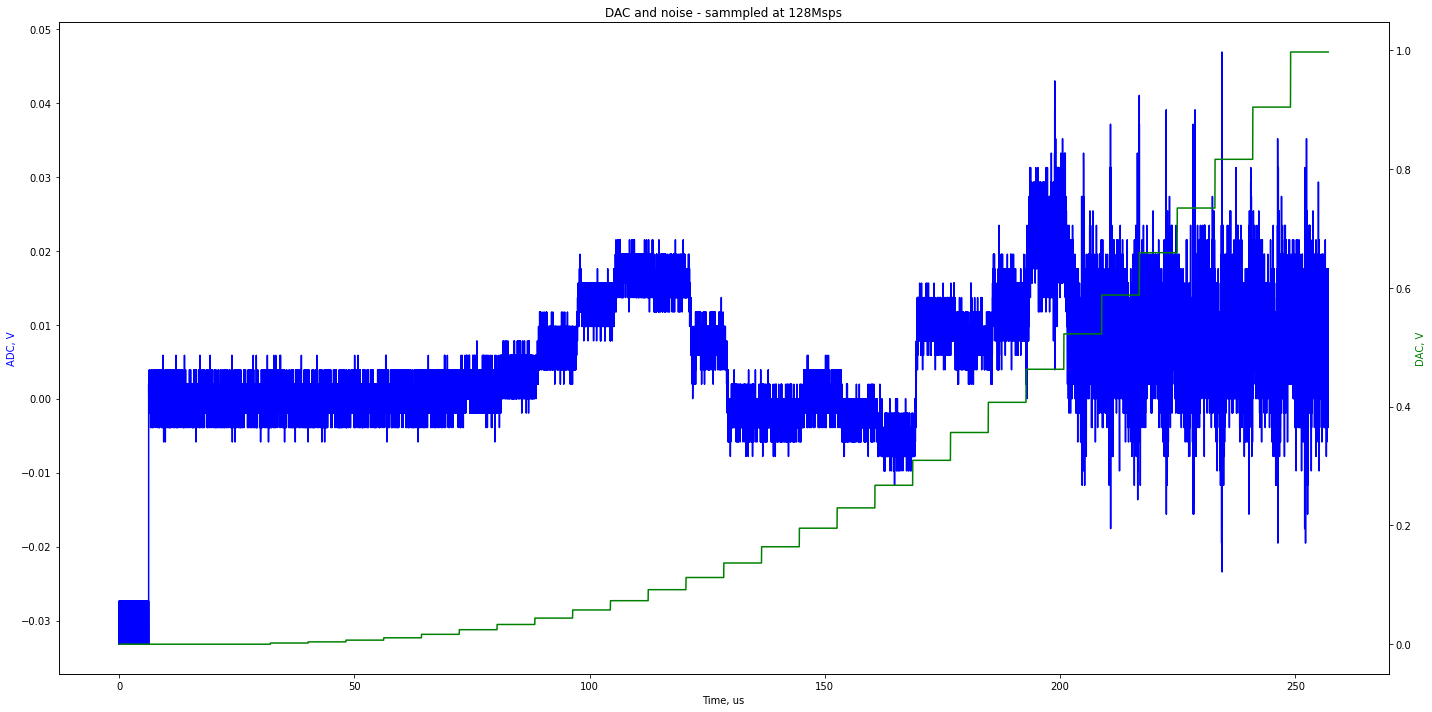

In [121]:
plot_interleaved_lines("DAC and noise - sammpled at 128Msps", line0, line1, gain=gain, xlim=None, dots=False)

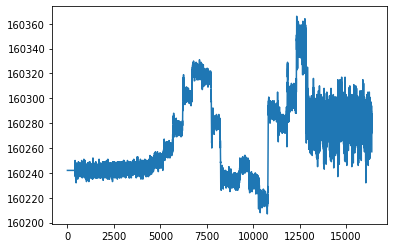

In [110]:

plt.plot(even)

Text(0.5, 0, 'MHz')

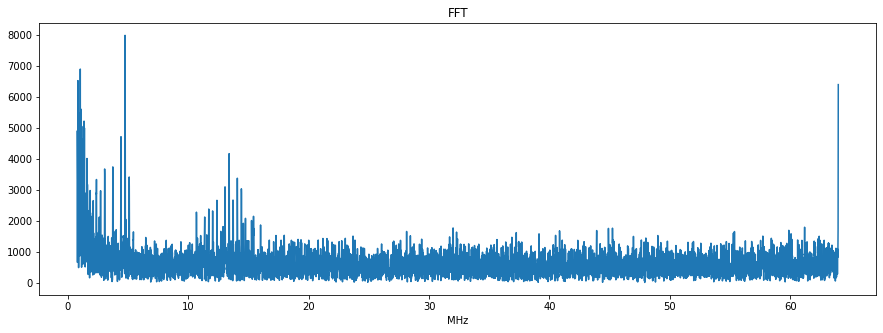

In [116]:
n = len(even)
FFT = np.abs(np.fft.fft(even))
f   = [x*128/n for x in range(n)]
plt.figure(figsize=(15,5))
plt.plot(f[100:int(n/2)],FFT[100:int(n/2)])
plt.title("FFT")
plt.xlabel("MHz")

## Disconnect FPGA

In [24]:
# reset fpga again (optional)
fpga.reset()
# close FTDI interface
fpga.disconnect()